# Assignment 4

### Samuel Sheehy (Student ID 18143565)

### Techniques of High Performance Computing (PHAS0102)

### MSc Scientific Computing, University College London, 2019-2020

**This Jupyter Notebook is submitted as completion of the 4th Assignment for the UCL course cited above.**

## Setup

In [1]:
import numpy as np
from scipy.sparse import coo_matrix, linalg
import matplotlib.pyplot as plt
from math import ceil

TRUE_RESULT = 0.424011387033 # The expected answer to 12 significant figures

## Introduction of Problem
* Intro to the problem we are solving and the Heat Equation 


## Mathematical Derivation of Numerical Scheme

* Finite difference method:

CN finite difference in spacial dimension.
$$
u_h(t, x, y) = u_h(t - \tau, x, y) -  \frac{\tau}{h^2} \left[ 4 u_h(t - \tau, x, y)
- u_h(t - \tau, x - h, y) - u_h(t - \tau, x + h, y) - u_h(t - \tau, x, y - h) - u_h(t - \tau, x, y + h) \right] + again
$$

* How I formulate this as a matrix


## My Method
* From mathematical formulation, components of calculation are: 
    - Construction of matrices A(t) and A(t+1)
    - Calculate $u_* = A(t)u(t) + [bc]$ - maybe use OpenCL kernel?
    - Solve for $u(t+1)$: $A(t+1)u(t+1) = u_* $ (CG method -  preconditioner through LU decomposition)
    - Use secant method to find answer

## Analysis
* Show influence of size of timestep and spacestep in finding correct answer
* How time completion of each section increases with system size
* Overall convergence of final solution

In [2]:
### Helper Methods ###
def is_bc(i, j, M):
    """
    Check if the given coordinates correspond to a boundary.
    """
    if i == 0 or i == M - 1:
        return True
    elif j == 0 or j == M - 1:
        return True
    else:
        return False

    
def show(b):
    """
    Display an image of the solution on the square.
    
    TODO: generalise to any BC function
    """
    # Put flattened vector back into square
    M = int(len(b)**0.5)
    p = b.reshape(M, M)
    
    # Reinclude the original boundary conditions
    p = np.pad(p, 1)
    p[:, 0] = 0  # left bc
    p[:, -1] = 0 # right bc
    p[-1, :] = 0 # top bc
    p[0, :] = 5  # bottom bc

    # Display the solution
    plt.imshow(p, origin='lower')
    plt.colorbar()
    plt.show()

In [42]:
# Crank-Nicholson Method
def build_CN_system(tau, h0):
    """
    Build a matrix which applies the Crank-Nicholsong finite difference
    scheme to solve the problem.
    
    TODO: Generalise region limits and boundary conditions
    """
    data = []
    dataprime = []
    rows = []
    cols = []
    
    # Double the size of M since its dimensions corners
    # oppose themselves around the center.
    M = ceil(2/h0)
    
    # Ensure that M is odd so that there is a unique value
    # at its center.
    if M % 2 == 0:
        M += 1
    
    # Redefine h to fit the number of descritisation points
    h = 2/M
    print('M:', M)
        
    # Determine the length of the operator
    M_op = (M-2)**2 # Removes edges
    b = np.zeros(M_op)
    
    # Set stepping term
    alpha = tau/h**2/2
    
    
    def add(datasource, val, row, colshift, flag=1):
        """
        Add coefficient to operator.
        """
        datasource.append(val)
        if flag:
            rows.append(row)
            if row+colshift < 0:
                raise Exception(f'Negative col index {row}: {colshift}')
            cols.append(row+colshift)
    
    k = 0
    for row_idx in range(1, M-1):
        for col_idx in range(1, M-1):

            # Consider Boundary influences
            if is_bc(row_idx + 1, col_idx, M):
                b[k] += 0 
                
            if is_bc(row_idx - 1, col_idx, M):
                b[k] += 5*alpha
                
            if is_bc(row_idx, col_idx + 1, M):
                b[k] += 0
                
            if is_bc(row_idx, col_idx - 1, M):
                b[k] += 0
            
            # Matrix
            if is_bc(row_idx, col_idx, M):
                raise Exception('Adding a bc to matrix - not correct')
            
            # center
            add(data,      1 - 4*alpha, k, 0)
            add(dataprime, 1 + 4*alpha, k, 0, 0)
            
            # left
            if col_idx >= 2:
                add(data,       alpha, k, -1)
                add(dataprime, -alpha, k, -1, 0)
            
            # right
            if col_idx < M - 2:
                add(data,       alpha, k, 1)
                add(dataprime, -alpha, k, 1, 0)
            
            # top
            if row_idx < M - 2:
                add(data,       alpha, k, M - 2)
                add(dataprime, -alpha, k, M - 2, 0)
            
            # bottom
            if row_idx >= 2:
                add(data,       alpha, k, -(M - 2))
                add(dataprime, -alpha, k, -(M - 2), 0)
            
            k += 1
            
    # Check for negative column indexes
    if any([x<0 for x in cols]):
        print(cols)
        raise Exception('Negative column index')

    A      = coo_matrix((data,      (rows, cols))).tocsc()
    Aprime = coo_matrix((dataprime, (rows, cols))).tocsc()
    
    # Ensure matrix is square
    if A.shape[0] != A.shape[1]:
        print('shape:', A.shape)
        return A, b
        raise Exception(f'Matrix is not square: {A.shape}')
    
    # Ensure it's the expected size
    if A.shape[0] != M_op:
        raise Exception(f'Matrix wrong size:{A.shape[0]}')
                
    return A, Aprime, b


def temp_at_time(t, h, tau):
    """
    Calculates the temperature at the central point at a given
    time t, according to a spacial step h and a time step tau.
    """
    # Get operators and boundary condition operator
    At, At2, bounds = build_CN_system(tau, h)
    
    # Initialise the estimate for the lattice solution
    u = np.empty_like(bounds)*0
    
    # Determine number of timesteps
    nt = ceil(t/tau)
    tau = t/nt
    T = 0
    print('nt:', nt)
    
    # Effectuate iteration until time reached
    for i in range(nt):
        u_temp = (At @ u + 2*bounds)
        u, info = linalg.cg(At2, u_temp)
        # Check convergence status of solution
        if info > 0:
            print(f'Did not converge at i={i}! iter:', info)
        if info < 0:
            print(f'There was an error in cg at i={i}')
        T += tau
        
#     print(T)
    return u


def secant_method(f, rhs, x0, x1, tol, maxiter=1000):
    """
    Using the secant method, solve the system f(x) = rhs.
    """
    # Initiate parameters
    fzero = lambda x: f(x) - rhs
    x_1 = x1
    x_0 = x0
    k = 0
    # Iterate
    while abs(x_1 - x_0) > tol and k < maxiter:
        f1 = fzero(x_1)
        f0 = fzero(x_0)
        x_new = x_1 - f1*(x_1 - x_0)/(f1 - f0)
        x_0 = x_1
        x_1 = x_new
        k += 1
        print(x_new)
    
    print('k:', k)
    if k == maxiter:
        print('WARNING: solver exited before finding a solution')
    return x_new


def get_center_value(u):
    """
    Return the value at the center of the lattice
    """
    return u[len(u)//2]


def center_temp_at_time(t, h, tau):
    """
    Determine the temparature at the center of the lattice
    at the time t for th given step sizes h and tau.
    """
    u = temp_at_time(t, h, tau)
    center = get_center_value(u)
    return center

    
def main_solve(h, tau, tol):
    """
    Determine the solution of the initial problem.
    """
    x0 = 0.4
    x1 = 0.3
    f = lambda t: center_temp_at_time(t, h, tau)
    center_T = secant_method(f, 1, x0, x1, tol)
    return center_T

In [ ]:
# Setup
h = 1e-2
tau = 0.01
tol = 1e-2

# Solve
estimate = main_solve(h, tau, tol)

# Error
print(f'Error from correct solution is {abs(estimate - TRUE_RESULT): 4E}')

M: 201
nt: 30
M: 201
nt: 40
0.4148483301921666
M: 201
nt: 42
M: 201
nt: 30


M: 129
nt: 425


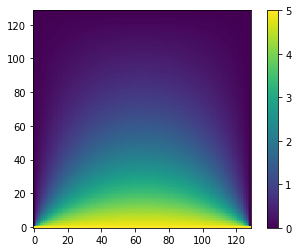

In [38]:
U = temp_at_time(TRUE_RESULT, 1/64, 1e-3)
show(U)

In [44]:
center_temp_at_time(TRUE_RESULT, 1e-2, 1e-2)

M: 201
nt: 43


1.0118953569901663

In [ ]:
center_temp_at_time(TRUE_RESULT, 1/64, 1e-4)

In [41]:
get_center_value(U)/3

0.41637375387367076

In [37]:
U

array([2.49966666e+00, 3.48759526e+00, 3.95205224e+00, ...,
       1.00029415e-03, 6.67216964e-04, 3.33711363e-04])

In [39]:
TRUE_RESULT

0.424011387033